In [1]:
import pandas as pd
import numpy as np
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from datetime import datetime
import time
from scipy.interpolate import interp1d
import statsmodels.api as sm
import itertools
import seaborn as sns
import math
from numpy import mean
# 设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
sns.set_context("paper")

### 导入数据

In [2]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)
df

,日期,DATA_DT,内存负载,主机CPU平均负载
0,2020-03-01 01:00:00,1582995600,81.8242,2.8333
1,2020-03-01 02:00:00,1582999200,81.8145,3.1818
2,2020-03-01 03:00:00,1583002800,81.8092,3.0833
3,2020-03-01 04:00:00,1583006400,81.8042,3.0833
4,2020-03-01 05:00:00,1583010000,81.8333,2.5000
...,...,...,...,...
2202,2020-05-31 19:00:00,1590922800,70.6183,2.0000
2203,2020-05-31 20:00:00,1590926400,70.5208,1.9167
2204,2020-05-31 21:00:00,1590930000,70.5608,1.7500
2205,2020-05-31 22:00:00,1590933600,70.5292,2.0000


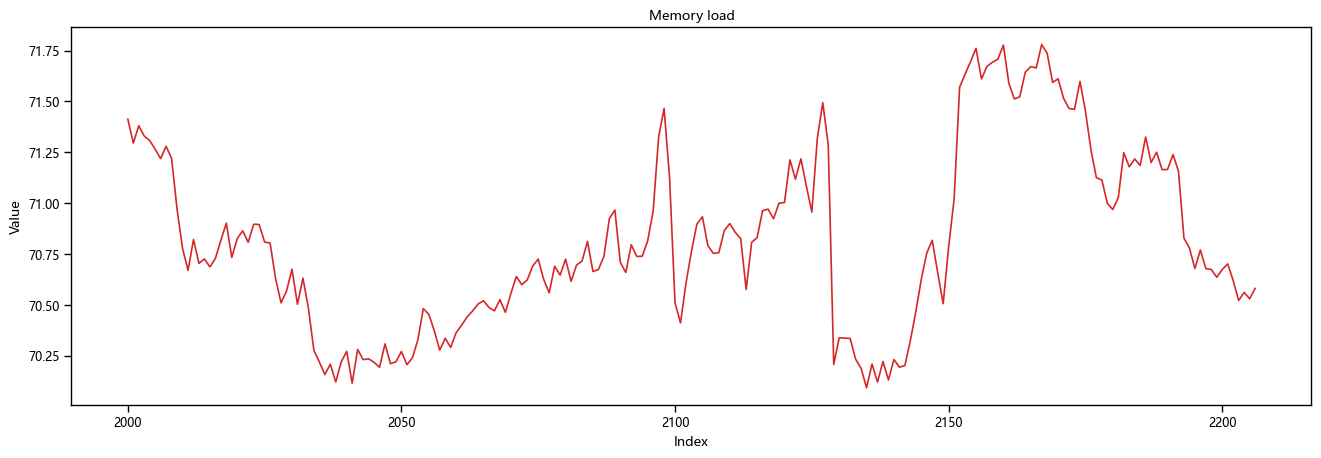

In [3]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, x=(df.index)[2000:], y= df["内存负载"][2000:], title='Memory load')         

In [4]:
# arr_temp = df2["内存负载"][0:288].values
arr_temp = [i*5 for i in range(288)]

In [5]:
import codecs
f = codecs.open(r'C:\Users\16526\Desktop\arr.txt','w')
for i in arr_temp:
    f.write(str(i))
    f.write('\n')
f.close()

### 缺失值填充

In [6]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df["内存负载"] = knn_mean(df["内存负载"], 24)

In [7]:
index = df.index
index[0:120]

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
           dtype='int64', length=120)

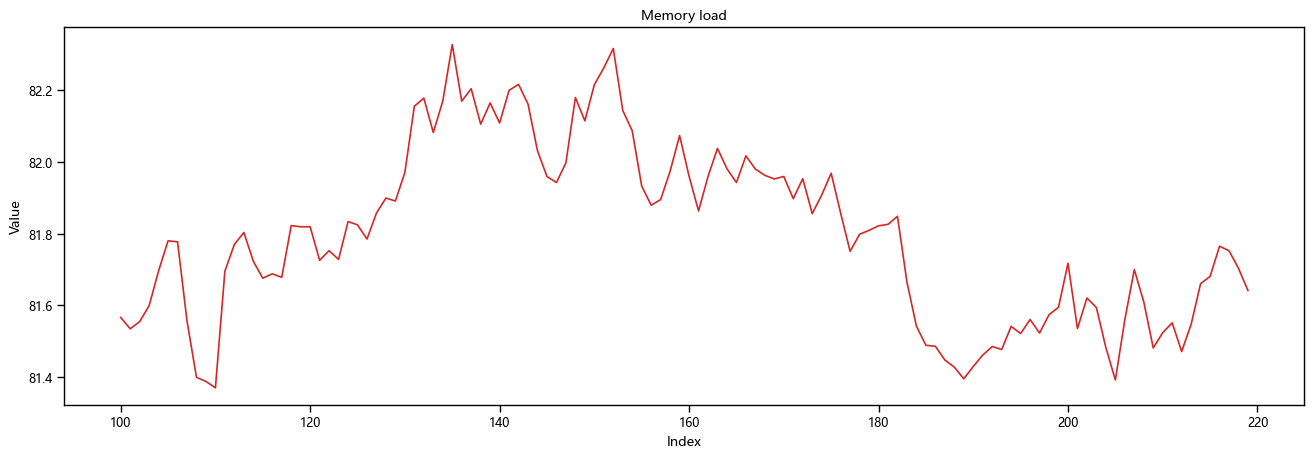

In [8]:
plot_df(df, x=(df.index)[100:220], y= df["内存负载"][100:220], title='Memory load')

In [9]:
df.loc[2201]

日期           2020-05-31 18:00:00
DATA_DT               1590919200
内存负载                     70.7008
主机CPU平均负载                 1.8333
Name: 2201, dtype: object

### 去除季节性因素

In [10]:
temp_Series =df["内存负载"]

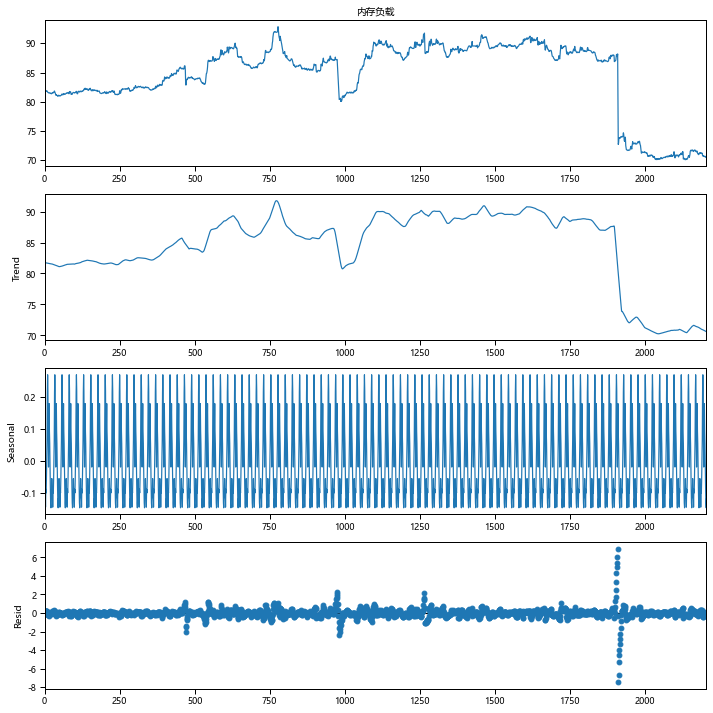

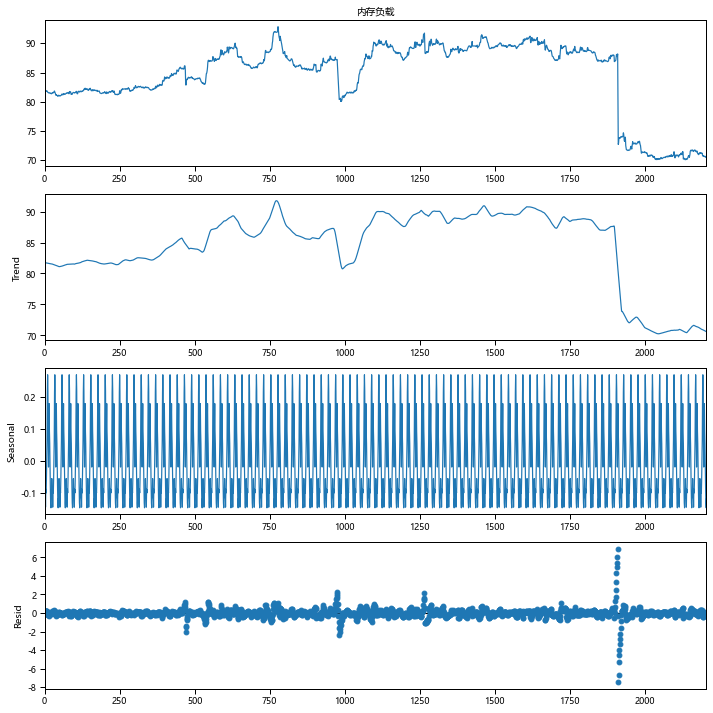

In [11]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_add = sm.tsa.seasonal_decompose(temp_Series, model='additive',period = 24, extrapolate_trend='freq')
result_add.plot()

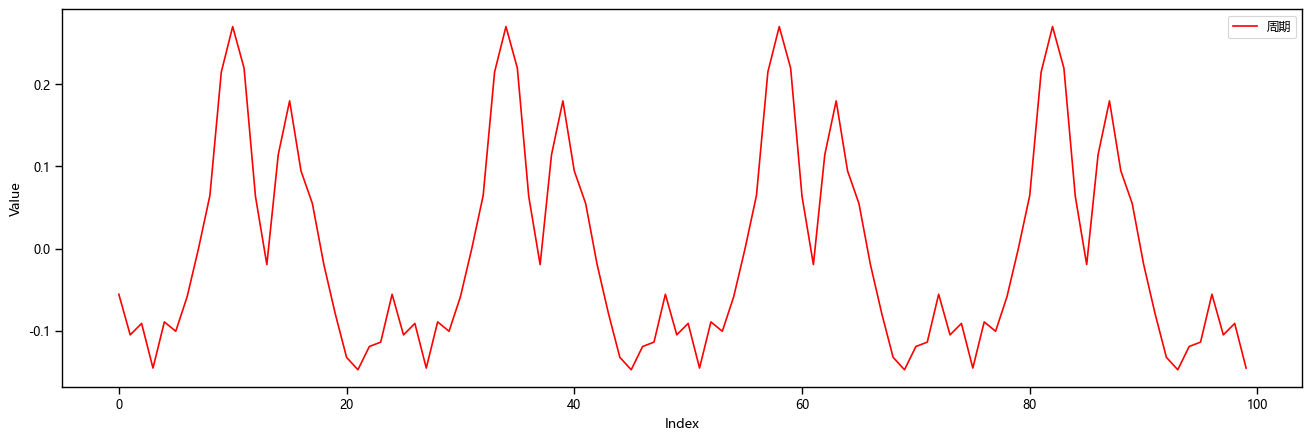

In [12]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot((result_add.seasonal)[0:100],label = '周期', color = 'red')
# plt.plot((result_add.trend)[0:100],label = '趋势', color = 'black')
# plt.plot((result_add.resid)[0:100],label = '随机', color = 'black')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(loc='best')

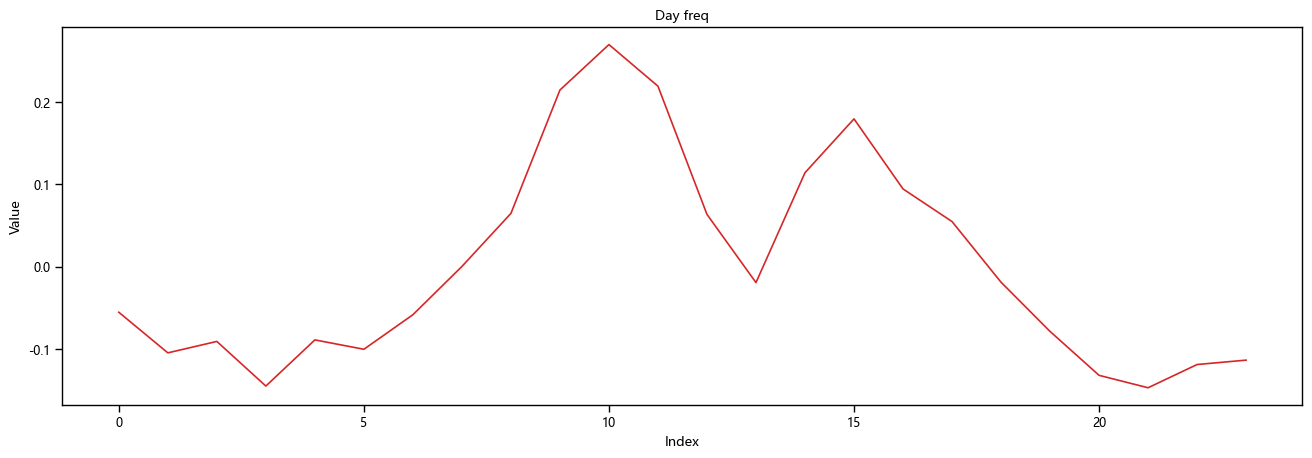

In [13]:
# 周期值24
a = result_add.seasonal
season = []
for i in range(24):
    season.append(float(format(a[i], '.6f')))
plot_df(season, x=range(24), y= season, title='Day freq')

In [14]:
arr = temp_Series - result_add.seasonal
arr

0       81.879860
1       81.919616
2       81.900399
3       81.949771
4       81.922626
          ...    
2202    70.637365
2203    70.599807
2204    70.693303
2205    70.676840
2206    70.699328
Length: 2207, dtype: float64

### 准备数据

In [15]:
region = 48
train = arr[0:2046+region]
test = arr[2046+region:2046+12+region]
train

0       81.879860
1       81.919616
2       81.900399
3       81.949771
4       81.922626
          ...    
2089    71.070916
2090    70.799499
2091    70.803871
2092    70.884326
2093    70.838257
Length: 2094, dtype: float64

In [16]:
adftrain = ts.adfuller(train)
adftrain

(-0.8281694336735954,
 0.8107071632128156,
 3,
 2090,
 {'1%': -3.4334827032362396,
  '5%': -2.862923892346305,
  '10%': -2.5675067196263823},
 438.064768421837)

### 9.预测

In [26]:
model = sm.tsa.ARIMA(train, order=(0, 1, 2))
result = model.fit()

In [46]:
result.params

const       -0.005269
ma.L1.D.y    0.543725
ma.L2.D.y    0.021808
dtype: float64

In [18]:
te = result.predict(start=1,end=2045+region, dynamic=False, typ='levels')
len(te.values)

2093

In [19]:
num = 12
result = model.fit()
foreca = result.forecast(num)
test_Y = foreca[0]
test_Y

array([70.80809144, 70.80182181, 70.7965532 , 70.79128459, 70.78601598,
       70.78074737, 70.77547876, 70.77021015, 70.76494154, 70.75967293,
       70.75440432, 70.74913571])

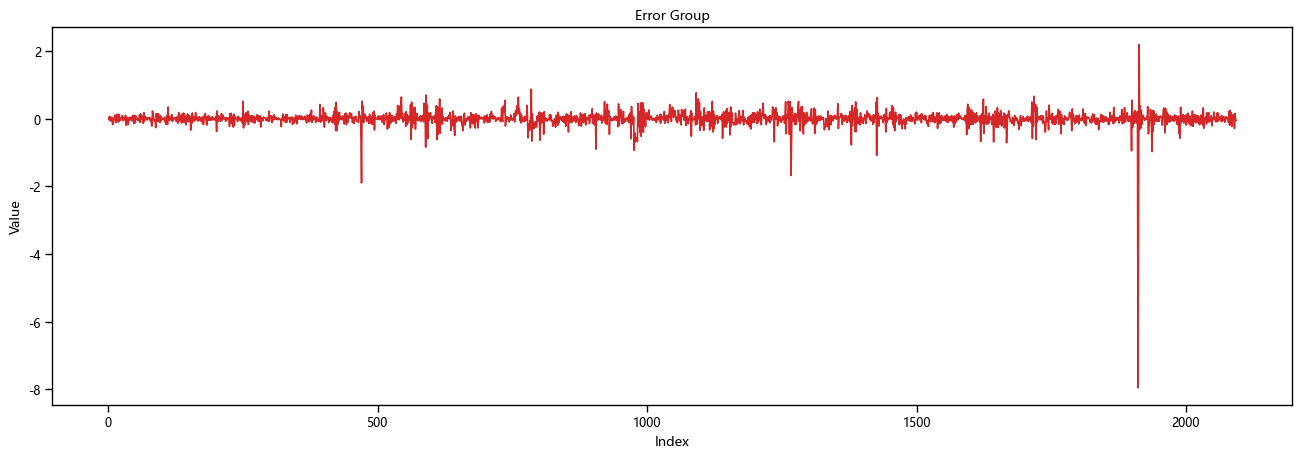

In [20]:
arr1 = train[1:2046+region] - te.values
error = pd.Series(arr1,index=te.index)
plot_df(error, x=error.index, y= error.values, title='Error Group')

In [21]:
temp = error[-168:].values
for i in temp:
    print(i)

-0.012850689490718992
0.05292790399967373
-0.009553128419199197
0.36321639656988225
-0.43911609800386486
-0.3948270058180725
-0.07018714549509752
0.00014353092662133804
0.2828801390009801
0.1075648318474407
-0.27733689876829715
-0.9649559598790489
0.24659099637597137
-0.36532292261226473
0.2395221966463339
-0.16266175102744285
0.051777033379238446
-0.051281524594969596
-0.06380079821383333
0.14633246237694664
-0.05602123891857502
0.045309937317682625
-0.07189138449108157
0.07140042379532474
-0.06987176344092916
0.03211017628242985
0.08470952040872248
0.054817410186473126
0.07071252449081555
0.06969191056140289
-0.18297623392344065
0.002939505141199561
0.28221961937498463
0.32026299800371305
0.2328281415650224
-0.4118841309592369
0.31724611644617084
-0.16250137305861756
0.21600214017223607
-0.16929646657391118
0.1542974248612552
-0.07527975955711952
0.051211867375499764
-0.09567947113525577
-0.04444145322341342
0.10009154967576706
-0.06523006436172807
0.02498380980676984
-0.043979149334

In [22]:
from scipy.interpolate import UnivariateSpline
from numpy import linspace,exp
from numpy.random import randn
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
error

1       0.045024
2      -0.033248
3       0.071050
4      -0.059342
5       0.049037
          ...   
2089    0.029599
2090   -0.284944
2091    0.163927
2092    0.002806
2093   -0.045901
Length: 2093, dtype: float64

In [23]:
error_temp = pd.DataFrame(error)
des = error_temp.describe()
U = des.iloc[6]
L = des.iloc[4]
IQR = U-L
top = U+1.5*IQR
bottom = L-1.5*IQR
des

,0
count,2093.000000
mean,-0.000011
std,0.267501
min,-7.956907
25%,-0.070033
50%,0.006779
75%,0.088155
max,2.200004


In [24]:
for i in range(len(error)):
    if (error.iloc[i] > top).bool():
        error.iloc[i] = np.nan
    if (error.iloc[i] < bottom).bool():
        error.iloc[i] = np.nan

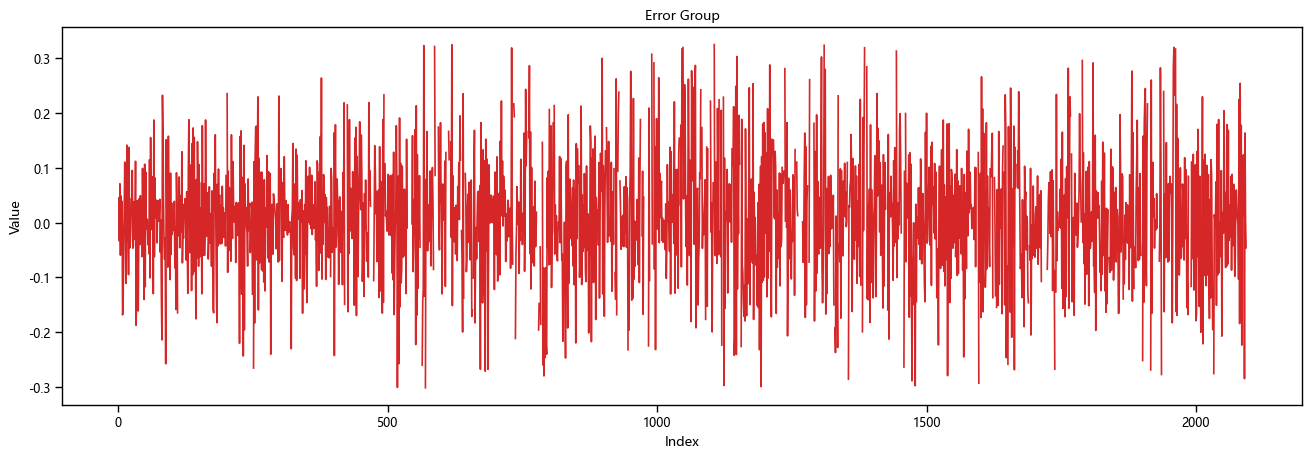

In [25]:
plot_df(error, x=error.index, y= error.values, title='Error Group')

In [26]:
error_temp2 = pd.DataFrame(error)
error_temp2.columns = ["value"]
print(f"缺失率为:{(100-(error_temp2.count()/(len(error))*100)).item()}%")

缺失率为:7.931199235547055%


In [27]:
error_temp2["value"] = knn_mean(error_temp2["value"], 9)

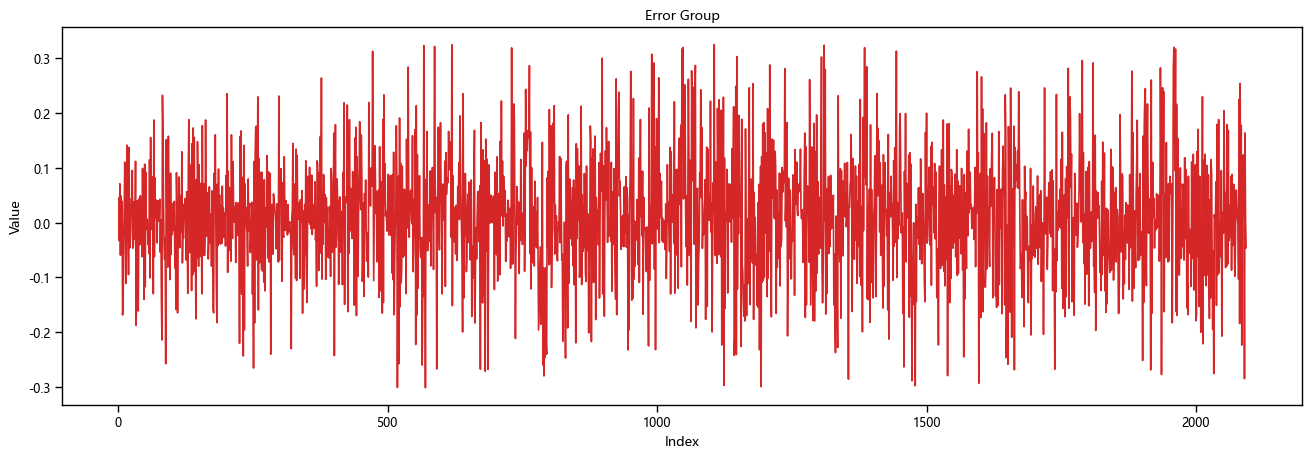

In [28]:
plot_df(error_temp2["value"], x=error_temp2["value"].index, y= error_temp2["value"].values, title='Error Group')

In [29]:
for i in (error_temp2["value"].values)[-168:]:
    print(i)

-0.012850689490718992
0.05292790399967373
-0.009553128419199197
-0.0065540367338964445
0.0330337237748982
0.05013220605281431
-0.07018714549509752
0.00014353092662133804
0.2828801390009801
0.1075648318474407
-0.27733689876829715
0.045814487438313733
0.24659099637597137
0.05463187785740686
0.2395221966463339
-0.16266175102744285
0.051777033379238446
-0.051281524594969596
-0.06380079821383333
0.14633246237694664
-0.05602123891857502
0.045309937317682625
-0.07189138449108157
0.07140042379532474
-0.06987176344092916
0.03211017628242985
0.08470952040872248
0.054817410186473126
0.07071252449081555
0.06969191056140289
-0.18297623392344065
0.002939505141199561
0.28221961937498463
0.32026299800371305
0.2328281415650224
0.09519160523859524
0.31724611644617084
-0.16250137305861756
0.21600214017223607
-0.16929646657391118
0.1542974248612552
-0.07527975955711952
0.051211867375499764
-0.09567947113525577
-0.04444145322341342
0.10009154967576706
-0.06523006436172807
0.02498380980676984
-0.04397914933

(-0.5, 0.5)

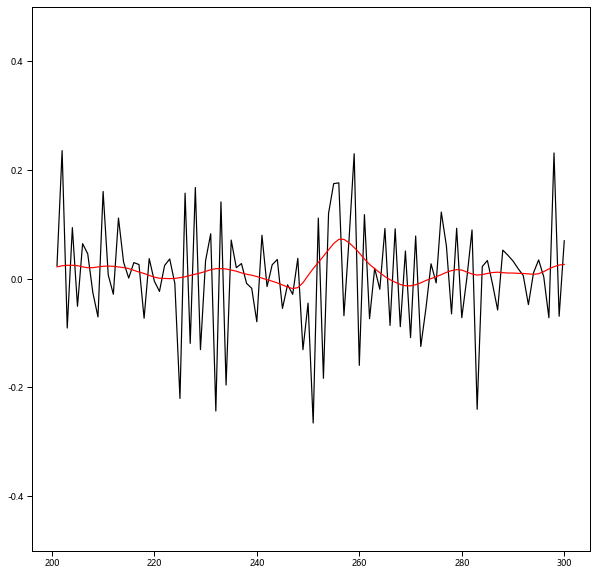

In [30]:
# Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(error_temp2["value"], np.arange(len(error_temp2["value"])), frac=0.008)[:, 1], index=error.index, columns=['value'])
# df_loess_15 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.15)[:, 1], index=df_orig.index, columns=['value'])
plt.plot(error[200:300],color = 'black')
plt.plot(df_loess_5[200:300],label = '拟合曲线',color = 'red')
plt.ylim(-.5,.5)

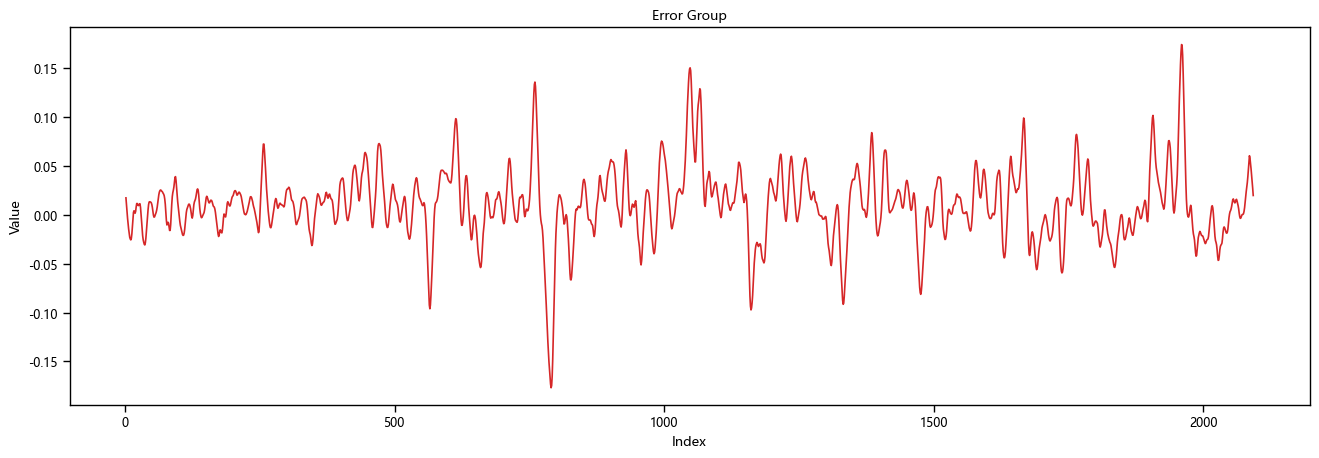

In [31]:
plot_df(df_loess_5, x=df_loess_5.index, y= df_loess_5.values, title='Error Group')

In [32]:
# 索引185指18点
truth = df_loess_5["value"].loc[168:2040+region]

In [33]:
# 每天的7点到18点的内存负载数据
# label矩阵 从第8天算共78天的误差数据,索引168:2039
label = [] 
for i in range(78+int(region/24)):
    arr = truth.loc[174+i*24:185+i*24].values
    label.append(arr)
# len(label) # 维度 78*12

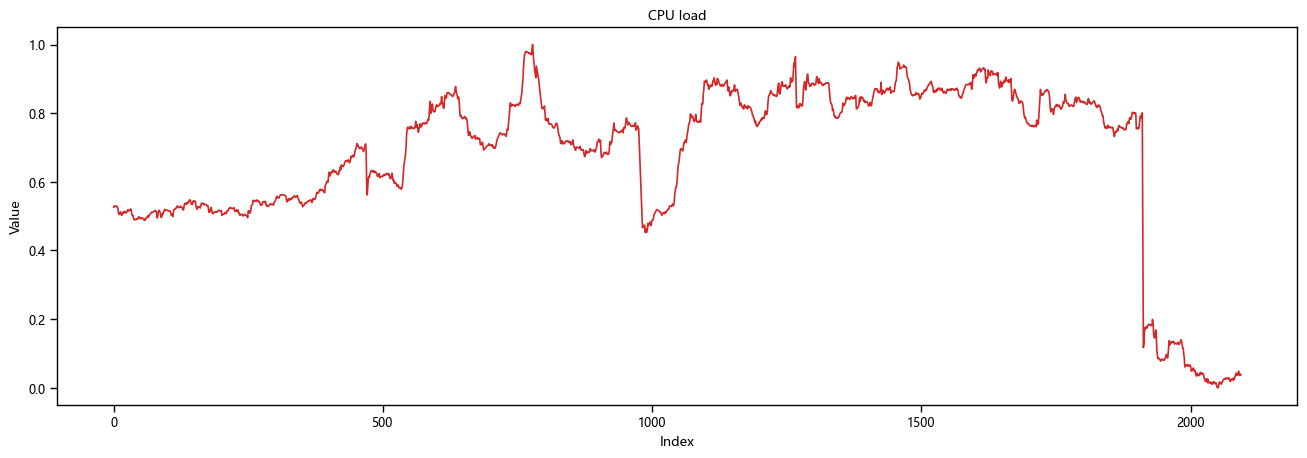

In [34]:
max_value = train.max(axis=0, skipna=True)
min_value = train.min(axis=0, skipna=True)
scalar = max_value - min_value
for i in range(len(train)):
    train[i]=(train[i]-min_value)/scalar
plot_df(df, x=df.index[0:2046+region], y= train, title='CPU load')

In [35]:
LSTM_input = []
for i in range(78+int(region/24)):
    arr = train.loc[6+i*24:173+i*24]
    LSTM_input.append(arr.values)
ma = pd.DataFrame(LSTM_input)
ma

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,0.527812,0.528083,0.521274,0.510411,0.505278,0.505143,0.510254,0.512641,0.507564,0.502258,...,0.537132,0.536106,0.538138,0.536276,0.532918,0.534665,0.534346,0.534021,0.534002,0.530190
1,0.517807,0.517126,0.521164,0.515305,0.504312,0.502229,0.502605,0.495147,0.489552,0.490301,...,0.512662,0.511893,0.512154,0.513322,0.511806,0.513620,0.515855,0.517378,0.516623,0.515464
2,0.494667,0.492767,0.490875,0.487713,0.491190,0.489200,0.493535,0.496781,0.496049,0.497170,...,0.514585,0.518612,0.522376,0.523034,0.524171,0.525808,0.523012,0.522692,0.523080,0.521740
3,0.515225,0.513950,0.507731,0.494724,0.499507,0.511862,0.517265,0.516184,0.512028,0.508928,...,0.504358,0.505915,0.505989,0.504796,0.500623,0.502003,0.502976,0.503609,0.505546,0.503767
4,0.515004,0.514358,0.515800,0.512847,0.510282,0.502747,0.502725,0.505887,0.499184,0.510673,...,0.544368,0.545739,0.544928,0.543885,0.543180,0.546588,0.544754,0.546608,0.544595,0.544583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.827161,0.825850,0.825867,0.839105,0.842409,0.837319,0.829607,0.833311,0.828087,0.825845,...,0.134551,0.131865,0.134597,0.134581,0.134952,0.131642,0.127186,0.130223,0.129468,0.128867
76,0.823658,0.820908,0.816345,0.807953,0.804910,0.798593,0.793145,0.792875,0.779162,0.768506,...,0.086941,0.060782,0.062185,0.064606,0.066819,0.066242,0.062932,0.067298,0.064586,0.065163
77,0.758443,0.759232,0.751906,0.740378,0.732056,0.738250,0.746899,0.746780,0.744874,0.748280,...,0.042874,0.038341,0.038048,0.036075,0.035339,0.041480,0.044588,0.039543,0.041184,0.043351
78,0.752132,0.751632,0.755303,0.769276,0.769444,0.773309,0.775908,0.769996,0.781633,0.787329,...,0.013463,0.016383,0.011254,0.015410,0.015113,0.010367,0.017094,0.017288,0.014983,0.014714


### 神经网络训练误差数据

In [36]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [37]:
train_X = torch.Tensor(np.array(LSTM_input).reshape(-1, 7, 24))
train_Y = torch.Tensor(np.array(label).reshape(-1, 1, 12))
train_X.shape

torch.Size([80, 7, 24])

In [38]:
test_X = torch.Tensor(np.array(df_loess_5["value"].loc[1878+region:2045+region]).reshape(-1, 7, 24))
test_X.shape

torch.Size([1, 7, 24])

In [39]:
class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer,batch_first=True)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        x = x[:,[6],:]
        b, s, h = x.size()
        x = x.view(-1,h)
        x = self.layer2(x)
        x = x.view(b, s, -1)
        return x

model = lstm(24, 128, 12, 2)
model

lstm(
  (layer1): LSTM(24, 128, num_layers=2, batch_first=True)
  (layer2): Linear(in_features=128, out_features=12, bias=True)
)

In [40]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epoch_n = 1000
# # 初始化 early_stopping 对象
# # 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
# patience = 20  

# # 关于 EarlyStopping 的代码可先看博客后面的内容
# early_stopping = EarlyStopping(patience, verbose=True)

In [41]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(epoch_n):
    var_x = Variable(train_X)
    var_y = Variable(train_Y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 5 == 0: # 每 2 次输出结果
        print('Epoch: {}, Loss: {:.8f}'.format(e + 1, loss.item()))
    ep.append(e+1)
    losses.append(loss.item())
#     break
    if (e+1)%500 == 0:
        for p in optimizer.param_groups:
            p['lr'] *= 0.1
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Epoch: 5, Loss: 0.00703812
Epoch: 10, Loss: 0.00293597
Epoch: 15, Loss: 0.00243617
Epoch: 20, Loss: 0.00209941
Epoch: 25, Loss: 0.00183148
Epoch: 30, Loss: 0.00178882
Epoch: 35, Loss: 0.00169689
Epoch: 40, Loss: 0.00170146
Epoch: 45, Loss: 0.00166639
Epoch: 50, Loss: 0.00164800
Epoch: 55, Loss: 0.00162372
Epoch: 60, Loss: 0.00160289
Epoch: 65, Loss: 0.00157856
Epoch: 70, Loss: 0.00155522
Epoch: 75, Loss: 0.00153244
Epoch: 80, Loss: 0.00151567
Epoch: 85, Loss: 0.00150290
Epoch: 90, Loss: 0.00149244
Epoch: 95, Loss: 0.00148146
Epoch: 100, Loss: 0.00147121
Epoch: 105, Loss: 0.00146062
Epoch: 110, Loss: 0.00152511
Epoch: 115, Loss: 0.00150886
Epoch: 120, Loss: 0.00146518
Epoch: 125, Loss: 0.00145668
Epoch: 130, Loss: 0.00144697
Epoch: 135, Loss: 0.00143050
Epoch: 140, Loss: 0.00141717
Epoch: 145, Loss: 0.00140111
Epoch: 150, Loss: 0.00138232
Epoch: 155, Loss: 0.00136895
Epoch: 160, Loss: 0.00136166
Epoch: 165, Loss: 0.00136080
Epoch: 170, Loss: 0.00132226
Epoch: 175, Loss: 0.00131158
Epoch

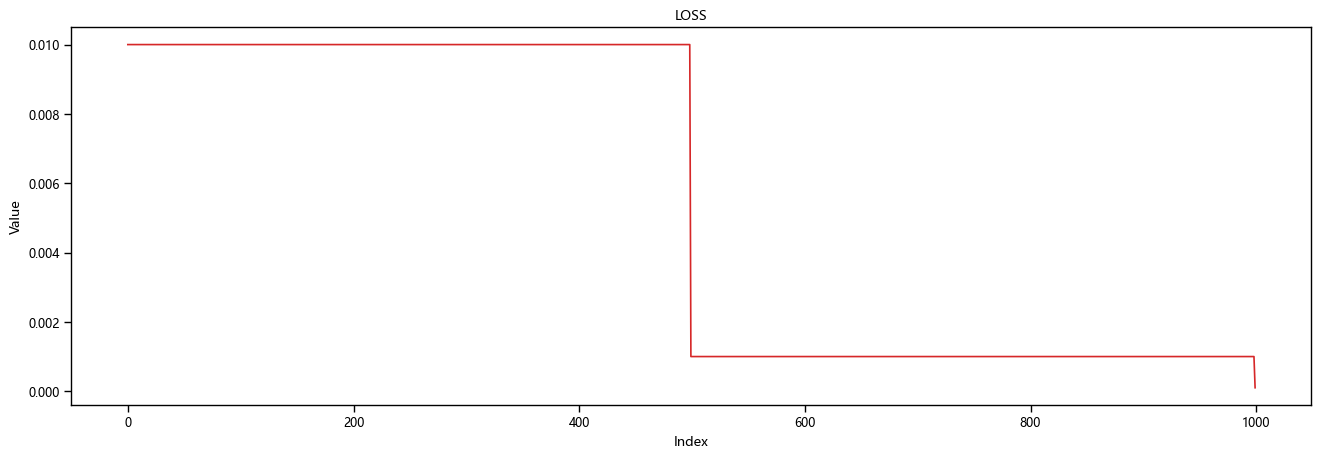

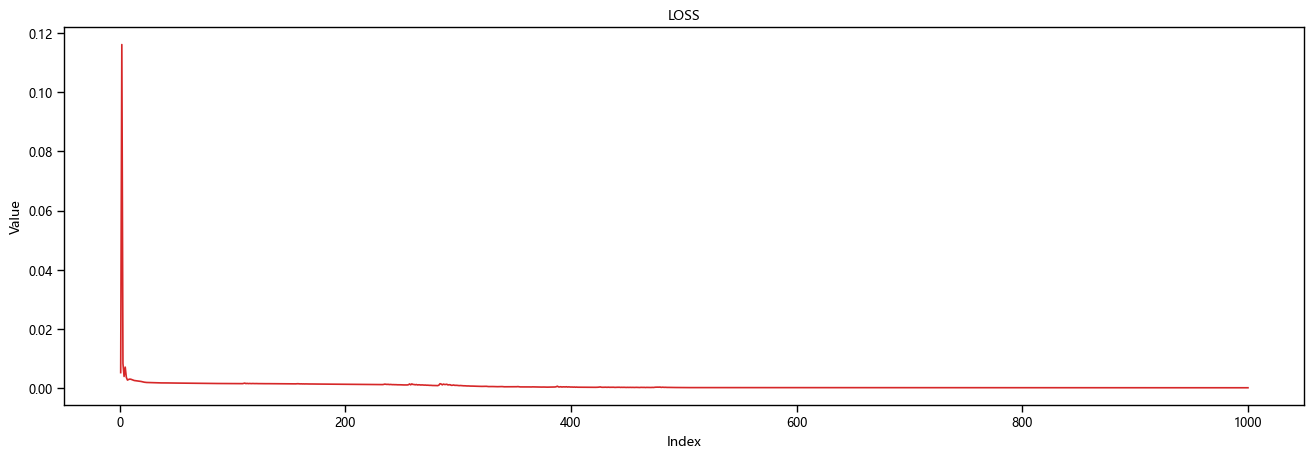

In [42]:
plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')
plot_df(df, x=ep, y= losses, title='LOSS')

### 检验神经网络模型效果

In [43]:
torch.save(model, 'error_net2.pkl')
model2 = torch.load('error_net2.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [44]:
foreca_val = test_Y+result_add.seasonal[6:num+6]
# 加上周期值
top = []
bottom = []
for data in foreca[2]:
    top.append(data[1])
    bottom.append(data[0])
top = top + result_add.seasonal[6:num+6]
bottom = bottom + result_add.seasonal[6:num+6]

In [45]:
MSEs = []
errors = []
truth = []
MAPEs = []
for i in range(num):
    err =  df["内存负载"].loc[2046+region+i] - foreca_val[6+i]
    truth.append(df["内存负载"].loc[2046+region+i])
    errors.append(err)
    MAPEs.append(abs(err/df["内存负载"].loc[2046+region+i])*100)
    MSEs.append((err)**2)
MSE = mean(MSEs)
sum1 = np.sum(MSEs)
RMSE = math.sqrt(MSE)
me = np.mean(truth)
R_temp = []
for i in range(num):
    err = df["内存负载"].loc[2046+region+i] - me
    R_temp.append(err**2)
sum2 = np.sum(R_temp)
R2 = 1 - sum1/sum2
R2

0.4045871005091153

In [46]:
RMSE

0.23159674232565883

In [47]:
ar = [1,2,3]
np.var(ar)

0.6666666666666666

In [48]:
MAPE = mean(MAPEs)
MAPE

0.2668668879324005

In [49]:
error

1       0.045024
2      -0.033248
3       0.071050
4      -0.059342
5       0.049037
          ...   
2089    0.029599
2090   -0.284944
2091    0.163927
2092    0.002806
2093   -0.045901
Length: 2093, dtype: float64

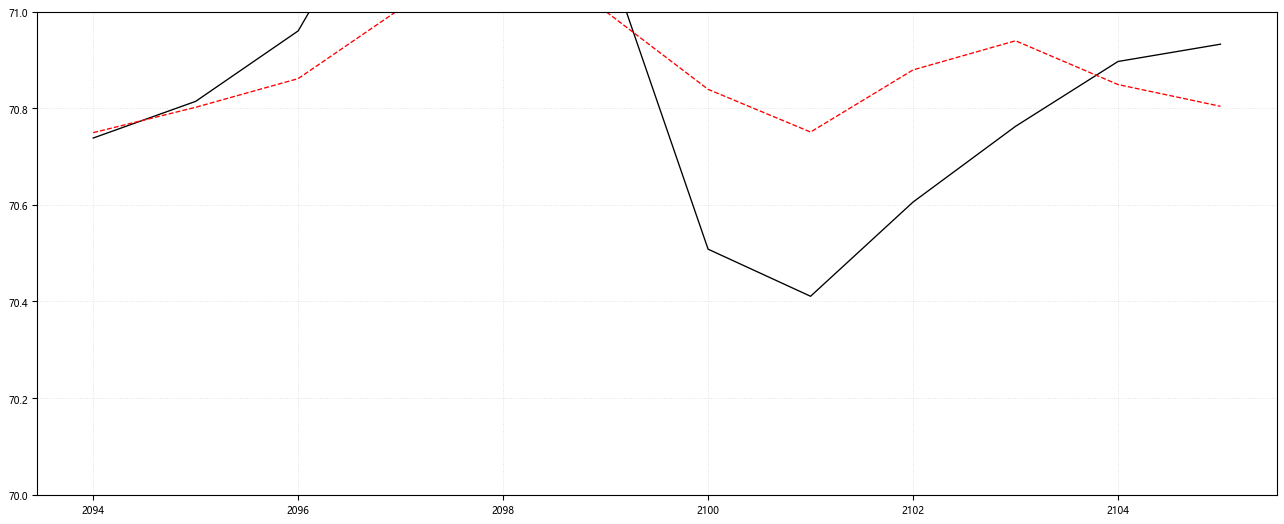

In [50]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
# color可以百度颜色代码
plt.plot(test_temp.index,test_temp,label="truth",color="black")
plt.plot(test_temp.index,foreca_val,label="predict",color="red",linestyle="--")
# plt.fill_between(test_temp.index,top,bottom,color='blue',alpha=0.05)
#绘制网格
plt.grid(alpha=0.4,linestyle=':')
plt.ylim(70,71)
#展示
plt.show()

In [51]:
outputs = model2(torch.Tensor(np.array(test_X).reshape(-1, 7, 24)))
error_list = outputs.detach().numpy().tolist()
error_list[0][0]

[-0.020538225769996643,
 -0.02361822873353958,
 -0.018628396093845367,
 -0.024461351335048676,
 -0.021633241325616837,
 -0.030160672962665558,
 -0.021935023367404938,
 -0.013944480568170547,
 -0.005208585411310196,
 -0.0017926469445228577,
 0.00878961756825447,
 0.008422154933214188]

In [52]:
prdict = foreca_val.values + error_list[0][0]
prdict_top = top + error_list[0][0]
prdict_bottom = bottom + error_list[0][0]

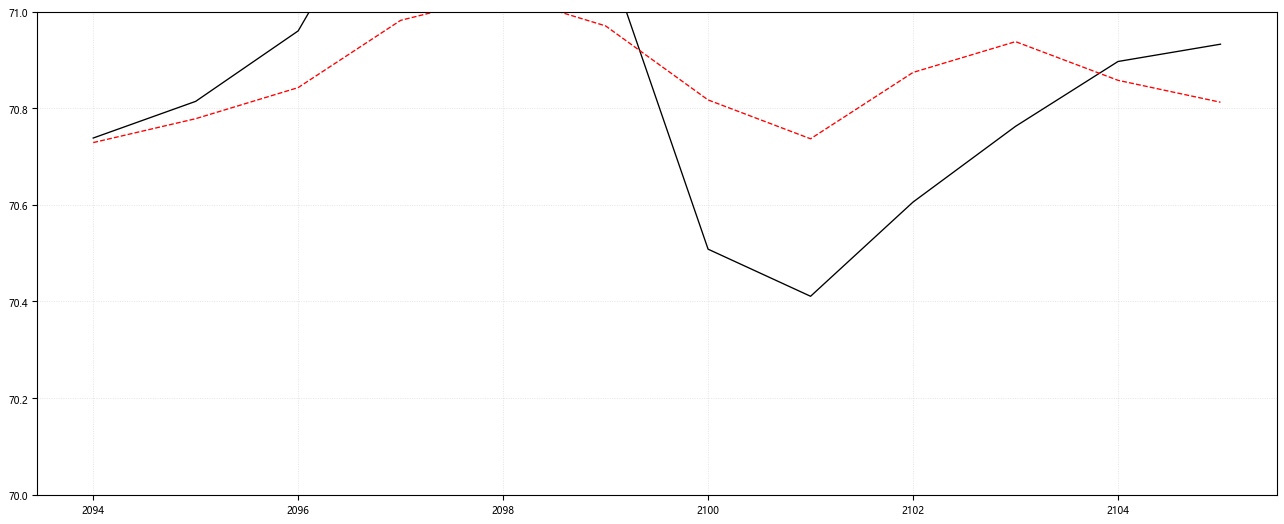

In [53]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
plt.plot(test_temp.index,test_temp,label="truth",color="black")
plt.plot(test_temp.index,prdict,label="predict",color="red",linestyle="--")
plt.grid(alpha=0.4,linestyle=':')
plt.ylim(70,71)
#展示
plt.show()

In [54]:
len(train)+num-36

2070

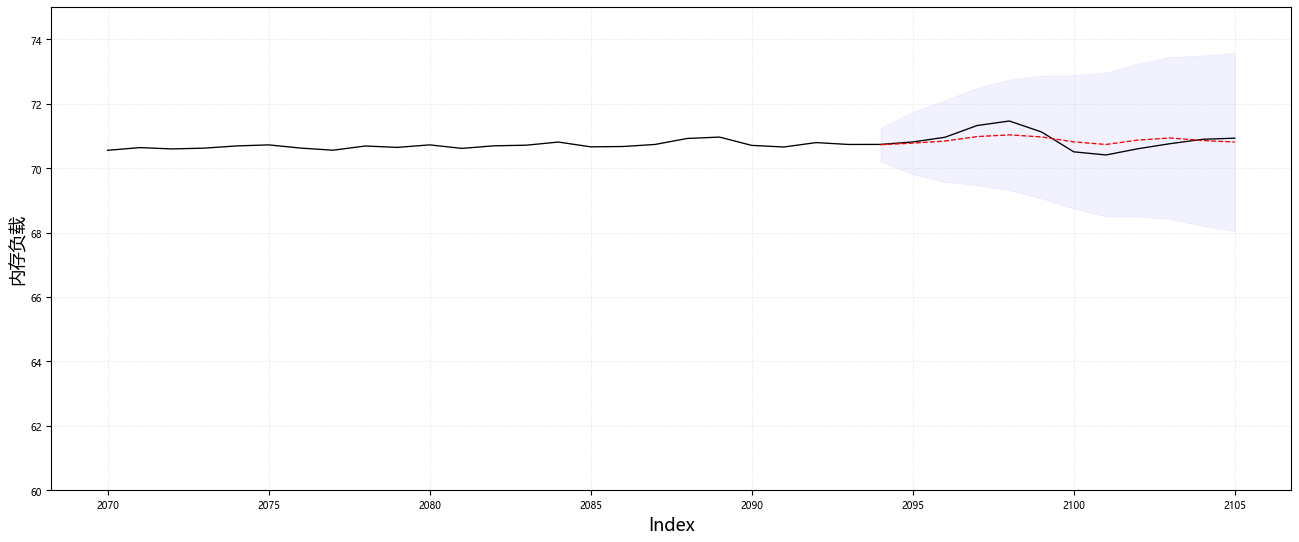

In [55]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
test_temp2 = df["内存负载"][len(train)+num-36:len(train)+num]
plt.plot(test_temp2.index,test_temp2,label="truth",color="black")
plt.plot(test_temp.index,prdict,label="predict",color="red",linestyle="--")
plt.fill_between(test_temp.index,prdict_top,prdict_bottom,color='blue',alpha=0.05)
plt.xlabel("Index",fontsize=16)
plt.ylabel("内存负载",fontsize=16)
plt.grid(alpha=0.4,linestyle=':')
plt.ylim(60,75)
#展示
plt.show()

In [56]:
for i in prdict_top:
    print(i)

71.25304879202665
71.74243318209784
72.10872233134813
72.49059272830557
72.75227964180169
72.87378883717552
72.88990854604172
72.966053413552
73.24959549386496
73.45107393832343
73.50161158728501
73.58067065088468


In [57]:
MSEs = []
errors = []
truth = []
MAPEs = []
for i in range(num):
    err =  df["内存负载"].loc[2046+region+i] - prdict[i]
    truth.append(df["内存负载"].loc[2046+region+i])
    errors.append(err)
    MAPEs.append(abs(err/df["内存负载"].loc[2046+region+i])*100)
    MSEs.append((err)**2)
MSE = mean(MSEs)
sum1 = np.sum(MSEs)
RMSE = math.sqrt(MSE)
me = np.mean(truth)
R_temp = []
for i in range(num):
    err = df["内存负载"].loc[2046+region+i] - me
    R_temp.append(err**2)
sum2 = np.sum(R_temp)
R2 = 1 - sum1/sum2
R2

0.38774527950311044

In [58]:
RMSE

0.23484936903352632

In [59]:
MAPE = mean(MAPEs)
MAPE

0.27345627805583045

In [60]:
errors

[0.009417371509798045,
 0.03587464349011782,
 0.11732967061243471,
 0.3431390052961518,
 0.43017638857733687,
 0.1538393827985658,
 -0.30882713911475435,
 -0.32594712387115976,
 -0.268255490935303,
 -0.17529439202789376,
 0.038941254712042905,
 0.12010347254391718]

### 差分

In [61]:
# # # 差分法生成序列
# dif = []
# dif = train.diff(1)

### ADF检验

In [62]:
# timeSeries = dif[1:]
# adftest = ts.adfuller(timeSeries)
# adftest

### ACF和PACF观察

In [63]:
# plot_acf(timeSeries).show()

In [64]:
# plot_pacf(timeSeries).show()

### BIC和AIC定阶

In [65]:
# p_min = 0
# q_min = 0
# p_max = 5
# q_max = 6
# d_min = 0
# d_max = 1

In [66]:
# results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
#                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
# results_bic

In [67]:
# num = 1
# for p,d,q in itertools.product(range(p_min,p_max+1),
#                                range(d_min,d_max+1),
#                                range(q_min,q_max+1)):
#     if p==0 and d==0 and q==0:
#         results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
#         continue
 
#     try:
#         model = sm.tsa.ARIMA(timeSeries, order=(p, d, q),
# #                                enforce_stationarity=False,
# #                                enforce_invertibility=False,
#                               )
#         results = model.fit()
#         num += 1
#         print(f"循环{num}次")
#         results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
#     except:
#         continue
# results_bic = results_bic[results_bic.columns].astype(float)
# fig, ax = plt.subplots(figsize=(10, 8))
# ax = sns.heatmap(results_bic,
#                  mask=results_bic.isnull(),
#                  ax=ax,
#                  annot=True,
#                  fmt='.2f',
#                  )
# ax.set_title('BIC')

### 验证模型

In [68]:
# from statsmodels.graphics.api import qqplot
# from statsmodels.stats.stattools import durbin_watson #DW检验
# #残差
# model = sm.tsa.ARIMA(timeSeries, order=(0, 1, 2))
# results = model.fit()
# resid = results.resid 
# #利用QQ图检验残差是否满足正态分布
# plt.figure(figsize=(12,8))
# qqplot(resid,line='q',fit=True)
# #利用D-W检验,检验残差的自相关性
# print('D-W检验值为{}'.format(durbin_watson(resid.values)))
# # 当D-W检验值接近于2时，不存在自相关性，说明模型较好。
# # https://wenku.baidu.com/view/57224dcfcf84b9d528ea7aba.html

### 绘制对比图

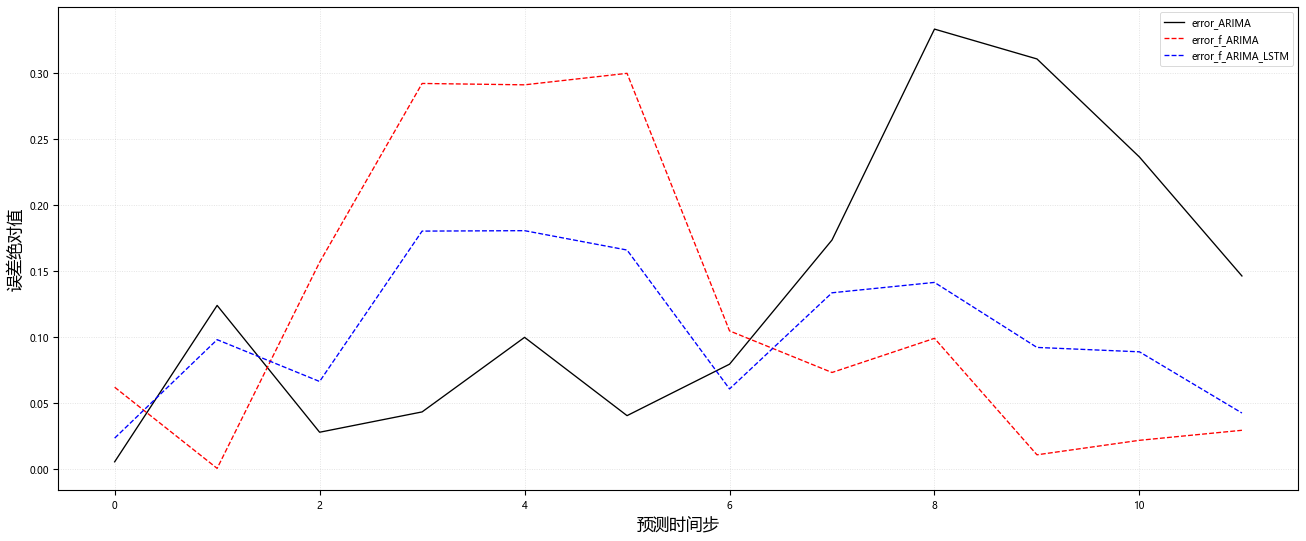

In [69]:
a1 = [-0.0051311868503631786,
 0.12361977310621342,
 0.0275387370117528,
 0.042940150495439866,
 0.09942670094049788,
 0.040113251385562876,
 0.0790998018306226,
 0.17318635227569246,
 0.33297290272075486,
 0.31035945316581603,
 0.23604600361088046,
 0.14593255405594618]
a2 = [-0.06163730216134411,
 0.00016395295655513564,
 -0.15632622916874084,
 -0.29178489161353127,
 -0.2907544402102218,
 -0.2994539195133399,
 -0.10432983371870819,
 0.0728056824368366,
 0.0986981686422439,
 0.010440164129136065,
 0.021423033494556876,
 -0.029017253195917192]
# a3 = errors



a3 = [0.023080761312357367,
 0.09767731572186733,
 -0.06599640329059753,
 -0.17992391599040047,
 -0.18025298692977287,
 -0.16557574806940067,
 -0.06035024854796234,
 0.13319505588830793,
 0.14105345646234468,
 0.09179544530331896,
 0.0884642815776715,
 -0.042101418947851244]




# a3 = [0.014428506373278083,
#  -0.015223932315947764,
#  -0.08774275560554656,
#  -0.22250850660424248,
#  -0.21295815237557747,
#  -0.21559197990428913,
#  -0.00848416421072784,
#  0.0809272548717388,
#  0.206503480322084,
#  0.023397208074925402,
#  0.035066499430740805,
#  0.07899878325494569]

for i in range(len(a3)):
    a1[i] = abs(a1[i])
    a2[i] = abs(a2[i])
    a3[i] = abs(a3[i])

x = range(12)
 
#设置图形大小
plt.figure(figsize=(20,8),dpi=80)
# color可以百度颜色代码
plt.plot(x,a1,label="error_ARIMA",color="black")
plt.plot(x,a2,label="error_f_ARIMA",color="red",linestyle="--")
plt.plot(x,a3,label="error_f_ARIMA_LSTM",color="blue",linestyle="--")
# plt.gca().set(title="", xlabel="", ylabel="",fontdict={'weight': 'normal', 'size': 14})
plt.xlabel('预测时间步', fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('误差绝对值', fontdict={'weight': 'normal', 'size': 15})
#绘制网格
plt.grid(alpha=0.4,linestyle=':')
plt.legend(loc='upper right')
#展示
plt.show()

In [70]:
truth = df["内存负载"].loc[2046+region:2046+region+11].values
pre1  = foreca_val.values
pre2 = truth - a1

In [71]:
MSEs = []
errors = []
MAPEs = []
for i in range(num):
    err =  truth[i] - pre2[i]
    errors.append(err)
    MAPEs.append(abs(err/truth[i])*100)
    MSEs.append((err)**2)
MSE = mean(MSEs)
sum1 = np.sum(MSEs)
RMSE = math.sqrt(MSE)
me = np.mean(truth)
R_temp = []
for i in range(num):
    err = truth[i] - me
    R_temp.append(err**2)
sum2 = np.sum(R_temp)
R2 = 1 - sum1/sum2
R2

0.6763537070082158

In [72]:
RMSE

0.1707491872290476

In [73]:
MAPE = mean(MAPEs)
MAPE

0.19028138557031082